In [1]:
# Import der Bibliotheken

import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import date, datetime

In [2]:
# Konfiguration der Grafiken

plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.autolayout'] = False

plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 12

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 8

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14


# Einlesen der Datenreihen

In [3]:
# Einlesen externen Daten
data_pv = pd.read_csv('data/data_pv_antofagasta_1MW.csv', skiprows = 3)
data_wind = pd.read_csv('data/data_wind_antofagasta_1MW.csv', skiprows = 3)
#data_electrolysis = pd.read_excel('data/load_electrolysis.xlsx')
data_shipping_1 = pd.read_excel('data/Ferntransport_12.xlsx')

In [4]:
# Erstellung eines Dataframes aus externen Daten

dataset_df=pd.DataFrame()
dataset_df['Zeitstempel']=data_pv['time']
dataset_df['PV_Erzeugung']=data_pv['electricity']
dataset_df['Wind_Erzeugung']=data_wind['electricity']
#dataset_df['Elektrolyse']=data_electrolysis['hydrogen']
dataset_df['Kapazität_Schiff']=data_shipping_1['10 Fahrten pro Jahr mit Betankung']
dataset_df.Kapazität_Schiff=dataset_df.Kapazität_Schiff.fillna(method='ffill')

In [5]:
# Einlesen und Ausgabe der Inputs für die Variablen

data_inputs = pd.read_excel('data/Inputs_Modell.xlsx', sheet_name = 'Gesamt', header = 2, index_col = 0, nrows = 16)

data_inputs=pd.DataFrame(data_inputs.fillna(0)).drop(columns = ['Unnamed: 1','name','bus','p_nom','Unnamed: 10']).round(2)
data_inputs

,marginal_cost,lifetime,capital_cost,efficiency,standing_loss
NaN,static,float,float,float,float
Photovoltaik (Chile),68.9,0,0,n.v.,n.v.
Windkraft (Chile),48.41,0,0,n.v.,n.v.
PEM Elektrolyse,95.226003,10,720000,0.598911,n.v.
AEL Elektrolyse,120.831319,10,630000,0.617978,n.v.
Verflüssigung,6.060606,20,3296969.69697,1,n.v.
Haber-Bosch,0,0,0,0,n.v.
Hydrierung,0,0,0,0,n.v.
GH2 Speicher,20.854545,20,1042.727273,n.v.,0
LH2 Speicher,21.818182,25,1090.909091,n.v.,0.000083


# Definition der Variablen

In [6]:
# Erstellung der Last durch den Wasserstoffbedarf

hydrogen_energy_content = 33 #kWh/kg oder MWh/t
hydrogen_demand_t = 35 * 1000
hydrogen_demand_kg = hydrogen_demand_t * 1000
hydrogen_demand_MWh = hydrogen_demand_t * hydrogen_energy_content # MWh
hydrogen_demand_hourly = hydrogen_demand_MWh/8760 #MW

print('Der stündliche Bedarf bei konstanter Verteilung des Jahresbedarfs von 35 kt Wasserstoff beträgt ungefähr ' + str(round(hydrogen_demand_hourly,0)) + ' MWh')

Der stündliche Bedarf bei konstanter Verteilung des Jahresbedarfs von 35 kt Wasserstoff beträgt ungefähr 132.0 MWh


In [7]:
# Erstellung der Last durch die Entsalzungsanlage

p_desalination = 0 #MWh/a)
print('Der stündliche Bedarf bei konstanter Verteilung des Jahresbedarfs für die Entsalzungsanlage beträgt ungefähr ' + str(round(p_desalination,0)) + ' MWh')

Der stündliche Bedarf bei konstanter Verteilung des Jahresbedarfs für die Entsalzungsanlage beträgt ungefähr 0 MWh


## Investitionskosten

In [8]:
# capital_cost

# Erzeugung
capital_cost_pv = data_inputs.loc['Photovoltaik (Chile)']['capital_cost'] # €/MW
capital_cost_wind = data_inputs.loc['Windkraft (Chile)']['capital_cost'] # €/MW


# Elektrolyse
capital_cost_PEMEL = data_inputs.loc['PEM Elektrolyse']['capital_cost'] # €/MW
capital_cost_AEL = data_inputs.loc['AEL Elektrolyse']['capital_cost'] # €/MW
#capital_cost_HTEL = 1300 # €/MW


# Umwandlung
capital_cost_LH2 = data_inputs.loc['Verflüssigung']['capital_cost'] # €/MW
capital_cost_NH3 = data_inputs.loc['Haber-Bosch']['capital_cost'] # €/MW
capital_cost_LOHC = data_inputs.loc['Hydrierung']['capital_cost'] # €/MW


#Transport
capital_cost_pipeline = data_inputs.loc['Pipeline']['capital_cost'] # €/MW
capital_cost_shipping_LH2 = data_inputs.loc['LH2 Schiff']['capital_cost'] # €/MW
capital_cost_shipping_NH3 = data_inputs.loc['NH3 Schiff']['capital_cost'] # €/MW
capital_cost_shipping_LOHC = data_inputs.loc['LOHC Schiff']['capital_cost'] # €/MW


# Speicherung
capital_cost_storage_el = 1000000
capital_cost_storage_NH3 = data_inputs.loc['LH2 Speicher']['capital_cost'] # €/MW
capital_cost_storage_LH2 = data_inputs.loc['NH3 Speicher']['capital_cost'] # €/MW
capital_cost_storage_LOHC = data_inputs.loc['LOHC Speicher']['capital_cost'] # €/MW
capital_cost_storage_GH2 = data_inputs.loc['GH2 Speicher']['capital_cost'] # €/MW

## Gestehungskosten

In [9]:
# marginal_cost

# Erzeugung
marginal_cost_pv = data_inputs.loc['Photovoltaik (Chile)']['marginal_cost'] # €/MWh
marginal_cost_wind = data_inputs.loc['Windkraft (Chile)']['marginal_cost'] # €/MWh

# Elektrolyse
marginal_cost_PEMEL = data_inputs.loc['PEM Elektrolyse']['marginal_cost'] # €/MWh
marginal_cost_AEL = data_inputs.loc['AEL Elektrolyse']['marginal_cost'] # €/MWh
#marginal_cost_HTEL = 100 # €/MWh

# Umwandlung
marginal_cost_LH2 = data_inputs.loc['Verflüssigung']['marginal_cost'] # €/MWh
marginal_cost_NH3 = data_inputs.loc['Haber-Bosch']['marginal_cost'] # €/MWh
marginal_cost_LOHC = data_inputs.loc['Hydrierung']['marginal_cost'] # €/MWh

# Transport
marginal_cost_pipeline = data_inputs.loc['Pipeline']['marginal_cost'] # €/MWh
marginal_cost_shipping_LH2 = data_inputs.loc['LH2 Schiff']['marginal_cost'] # €/MWh
marginal_cost_shipping_NH3 = data_inputs.loc['NH3 Schiff']['marginal_cost'] # €/MWh
marginal_cost_shipping_LOHC = data_inputs.loc['LOHC Schiff']['marginal_cost'] # €/MWh

# Speicherung
marginal_cost_storage_el = 8000
marginal_cost_storage_LH2 = data_inputs.loc['LH2 Speicher']['marginal_cost'] # €/MWh
marginal_cost_storage_NH3 = data_inputs.loc['NH3 Speicher']['marginal_cost'] # €/MWh
marginal_cost_storage_LOHC = data_inputs.loc['LOHC Speicher']['marginal_cost'] # €/MWh
marginal_cost_storage_GH2 = data_inputs.loc['GH2 Speicher']['marginal_cost'] # €/MWh

## Sonstiges

In [10]:
# Wirkungsgrad Erzeugung
efficiency_PEMEL = data_inputs.loc['PEM Elektrolyse']['efficiency']
efficiency_AEL = data_inputs.loc['AEL Elektrolyse']['efficiency']
#efficiency_HTEL = 1

# Wirkungsgrad Umwandlung
efficiency_NH3 = data_inputs.loc['Haber-Bosch']['efficiency']
efficiency_LH2 = data_inputs.loc['Verflüssigung']['efficiency']
efficiency_LOHC = data_inputs.loc['Hydrierung']['efficiency']

# Lebenszeit
lifetime_PEMEL = data_inputs.loc['PEM Elektrolyse']['lifetime']
lifetime_AEL = data_inputs.loc['AEL Elektrolyse']['lifetime']
#lifetime_HTEL = 20

# Speicherverluste
standing_loss_el = 0.1
standing_loss_NH3 = data_inputs.loc['LH2 Speicher']['standing_loss']
standing_loss_LH2 = data_inputs.loc['NH3 Speicher']['standing_loss']
standing_loss_LOHC = data_inputs.loc['LOHC Speicher']['standing_loss']
standing_loss_GH2 = data_inputs.loc['GH2 Speicher']['standing_loss']

# Netzwerk aufbauen

In [11]:
network = pypsa.Network()
network.set_snapshots(range(8760))

## Buses

In [12]:
# buses

network.add('Bus', name = 'electricity')
network.add('Bus', name = 'GH2')
network.add('Bus', name = 'LH2')
network.add('Bus', name = 'NH3')
network.add('Bus', name = 'LOHC')
network.add('Bus', name = 'bremerhaven')
network.add('Bus', name = 'cologne')

## Loads

In [13]:
network.add('Load', name = 'hydrogen_demand', bus = 'cologne', 
            p_set = hydrogen_demand_hourly)

network.add('Load', name = 'desalination', bus = 'electricity', 
            p_set = p_desalination)

## Generators

In [14]:
network.add('Generator', name = 'Photovoltaik', bus = 'electricity', 
            p_nom = dataset_df['PV_Erzeugung'].max(),
            p_max_pu = dataset_df['PV_Erzeugung']/dataset_df['PV_Erzeugung'].max(), 
            p_min_pu = dataset_df['PV_Erzeugung']/dataset_df['PV_Erzeugung'].max(), 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_pv, capital_cost = capital_cost_pv)

network.add('Generator', name = 'Windkraft', bus = 'electricity',
            p_nom = dataset_df['Wind_Erzeugung'].max(),
            p_max_pu = dataset_df['Wind_Erzeugung']/dataset_df['Wind_Erzeugung'].max(), 
            p_min_pu = dataset_df['Wind_Erzeugung']/dataset_df['Wind_Erzeugung'].max(), 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_wind, capital_cost = capital_cost_wind)

## Links - Electrolysis

In [15]:
network.add('Link', name = 'PEMEL', bus0 = 'electricity', bus1 = 'GH2',
            p_nom_extendable = True,
            lifetime = lifetime_PEMEL,
            marginal_cost = marginal_cost_PEMEL, 
            capital_cost = capital_cost_PEMEL,
            efficiency = efficiency_PEMEL)

network.add('Link', name = 'AEL', bus0 = 'electricity', bus1 = 'GH2',
            p_nom_extendable = True,
            lifetime = lifetime_AEL,
            marginal_cost = marginal_cost_AEL, 
            capital_cost = capital_cost_AEL,
            efficiency = efficiency_AEL)

#network.add('Link', name = 'HTEL', bus0 = 'electricity', bus1 = 'GH2',
#            p_nom_extendable = True,
#            lifetime = lifetime_HTEL,
#            marginal_cost = marginal_cost_HTEL, 
#            capital_cost = capital_cost_HTEL,
#            efficiency = efficiency_HTEL)

In [16]:
# Veraltete Abbildung der Elektrolyse mit dem hinterlegten Volllastprofil von 8000 h/a

#network.add('Link', name = 'PEMEL', bus0 = 'electricity', bus1 = 'GH2',
#            p_nom = dataset_df['Elektrolyse'].max(),
#            p_max_pu = dataset_df['Elektrolyse']/dataset_df['Elektrolyse'].max(), 
#            p_min_pu = dataset_df['Elektrolyse']/dataset_df['Elektrolyse'].max(), 
#            p_nom_extendable = True,
#            lifetime = lifetime_PEMEL,
#            marginal_cost = marginal_cost_PEMEL, 
#            capital_cost = capital_cost_PEMEL,
#            efficiency = efficiency_PEMEL)

## Links - Conversion

In [17]:
network.add('Link', name = 'Verflüssigung', bus0 = 'GH2', bus1 = 'LH2',
            p_nom_extendable = True,
            marginal_cost = marginal_cost_LH2, capital_cost = capital_cost_LH2,
            efficiency = efficiency_LH2)

#network.add('Link', name = 'Haber-Bosch', bus0 = 'GH2', bus1 = 'NH3',
#            p_nom_extendable = True,
#            marginal_cost = marginal_cost_NH3, capital_cost = capital_cost_NH3,
#            efficiency = efficiency_NH3)

#network.add('Link', name = 'Hydrierung', bus0 = 'GH2', bus1 = 'LOHC',
#            p_nom_extendable = True,
#            marginal_cost = marginal_cost_LOHC, capital_cost = capital_cost_LOHC,
#            efficiency = efficiency_LOHC)

In [18]:
# Veraltete Abbildung der Verflüssigung mit dem hinterlegten Volllastprofil von 8000 h/a

#network.add('Link', name = 'Verflüssigung', bus0 = 'GH2', bus1 = 'LH2',
#            p_nom = dataset_df['Elektrolyse'].max(),
#            p_max_pu = dataset_df['Elektrolyse']/dataset_df['Elektrolyse'].max(), 
#            p_min_pu = dataset_df['Elektrolyse']/dataset_df['Elektrolyse'].max(), 
#            p_nom_extendable = True,
#            marginal_cost = marginal_cost_LH2, capital_cost = capital_cost_LH2,
#            efficiency = efficiency_LH2)

## Links - Cargoship

In [19]:
network.add('Link', name = 'Verschiffung LH2', bus0 = 'LH2', bus1 = 'bremerhaven',
            p_nom = dataset_df['Kapazität_Schiff'].max(),
            p_max_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(), 
            p_min_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(),
            p_nom_extendable = True,
            marginal_cost = marginal_cost_shipping_LH2, 
            capital_cost = capital_cost_shipping_LH2)

network.add('Link', name = 'Verschiffung NH3', bus0 = 'NH3', bus1 = 'bremerhaven',
            p_nom = dataset_df['Kapazität_Schiff'].max(),
            p_max_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(), 
            p_min_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(),
            p_nom_extendable = True,
            marginal_cost = marginal_cost_shipping_NH3, 
            capital_cost = capital_cost_shipping_NH3)

network.add('Link', name = 'Verschiffung LOHC', bus0 = 'LOHC', bus1 = 'bremerhaven',
            p_nom = dataset_df['Kapazität_Schiff'].max(),
            p_max_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(), 
            p_min_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(),
            p_nom_extendable = True,
            marginal_cost = marginal_cost_shipping_LOHC, 
            capital_cost = capital_cost_shipping_LOHC)

## Links - Pipeline

In [20]:
network.add('Link', name = 'Pipeline', bus0 = 'bremerhaven', bus1 = 'cologne', 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_pipeline, 
            capital_cost = capital_cost_pipeline)

## Storages

In [21]:
network.add('Store', name = 'Stromspeicher', bus = 'electricity', 
            e_nom_extendable = True,  e_cyclic = True, 
            capital_cost = capital_cost_storage_el,
            marginal_cost = marginal_cost_storage_el)

network.add('Store', name = 'Flüssigspeicher', bus = 'LH2', 
            e_nom_extendable = True, e_cyclic = True,  
            capital_cost = capital_cost_storage_LH2, 
            marginal_cost = marginal_cost_storage_LH2)

network.add('Store', name = 'Ammoniakspeicher', bus = 'NH3', 
            e_nom_extendable = True,  e_cyclic = True, 
            capital_cost = capital_cost_storage_NH3, 
            marginal_cost = marginal_cost_storage_NH3)

network.add('Store', name = 'LOHC-Speicher', bus = 'LOHC', 
            e_nom_extendable = True, e_cyclic = True,  
            capital_cost = capital_cost_storage_LOHC, 
            marginal_cost = marginal_cost_storage_LOHC)

network.add('Store', name = 'Gasspeicher', bus = 'bremerhaven', 
            e_nom_extendable = True, e_cyclic = True, 
            capital_cost = capital_cost_storage_GH2, 
            marginal_cost = marginal_cost_storage_GH2)

# Optimierung des Systems

In [22]:
network.lopf(pyomo = False, solver_name = 'gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.34s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-01
Read LP format model from file /var/folders/np/fxyv4bts2s353fj5gdlrbgym0000gn/T/pypsa-problem-vc1gkkll.lp
Reading time = 0.81 seconds
obj: 350400 rows, 166455 columns, 693162 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 350400 rows, 166455 columns and 693162 nonzeros
Model fingerprint: 0x11d6f634
Coefficient statistics:
  Matrix range     [1e-06, 1e+00]
  Objective range  [1e+00, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 1e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 286938 rows and 129703 columns
Presolve time: 0.40s
Presolved: 63462 rows, 36752 columns, 208507 nonzeros

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 10
 AA' NZ     : 1.832e+05
 Factor NZ  : 7.908e

INFO:pypsa.linopf:Optimization successful. Objective value: 2.43e+09


('ok', 'optimal')

# Auswertung der Ergebnisse

In [23]:
# Ausgabe einer Ergebnistabelle der Leistungen in MW und Kapazitäten in MWh

df_results_1 = pd.DataFrame(network.generators['p_nom_opt'])
df_results_2 = pd.DataFrame(network.links['p_nom_opt'])
df_results_3 = pd.DataFrame(network.stores['e_nom_opt'])

frames = [df_results_1, df_results_2, df_results_3]

results_x = (pd.concat(frames).round(2).fillna(0).rename(columns = {'p_nom_opt':'Leistung [MW]','e_nom_opt':'Kapazität [MWh]'}))
results = results_x.loc[(results_x.sum(axis=1) != 0), (results_x.sum(axis=0) != 0)]


results

,Leistung [MW],Kapazität [MWh]
Photovoltaik,756.15,0.00
Windkraft,38.91,0.00
AEL,730.56,0.00
Verflüssigung,451.47,0.00
Verschiffung LH2,279.66,0.00
Pipeline,131.85,0.00
Stromspeicher,0.00,53.38
Flüssigspeicher,0.00,77428.74
Gasspeicher,0.00,57702.59


In [24]:
# Berechnung der jährlichen Volllaststunden

df_flh_1 = pd.DataFrame((network.generators_t.p.sum())/network.generators.p_nom_opt)
df_flh_2 = pd.DataFrame((network.links_t.p0.sum())/network.links.p_nom_opt)

df_flh_x = df_flh_1.append(df_flh_2).round(0).fillna(0)
df_flh = df_flh_x.loc[(df_flh_x.sum(axis=1) != 0), (df_flh_x.sum(axis=0) != 0)]
#df_flh = df_flh.rename(columns = {'0','Volllast [h]'})
df_flh

,0
Photovoltaik,2437.0
Windkraft,671.0
AEL,2558.0
Verflüssigung,2558.0
Verschiffung LH2,4130.0
Pipeline,8760.0


In [25]:
#TODO: Hier alle Ergebnisse (Leistung/Kapazität/Volllaststunden) in einen DF zu packen

results_sum = pd.concat([results,df_flh])
#results_sum

## Grafische Darstellungen

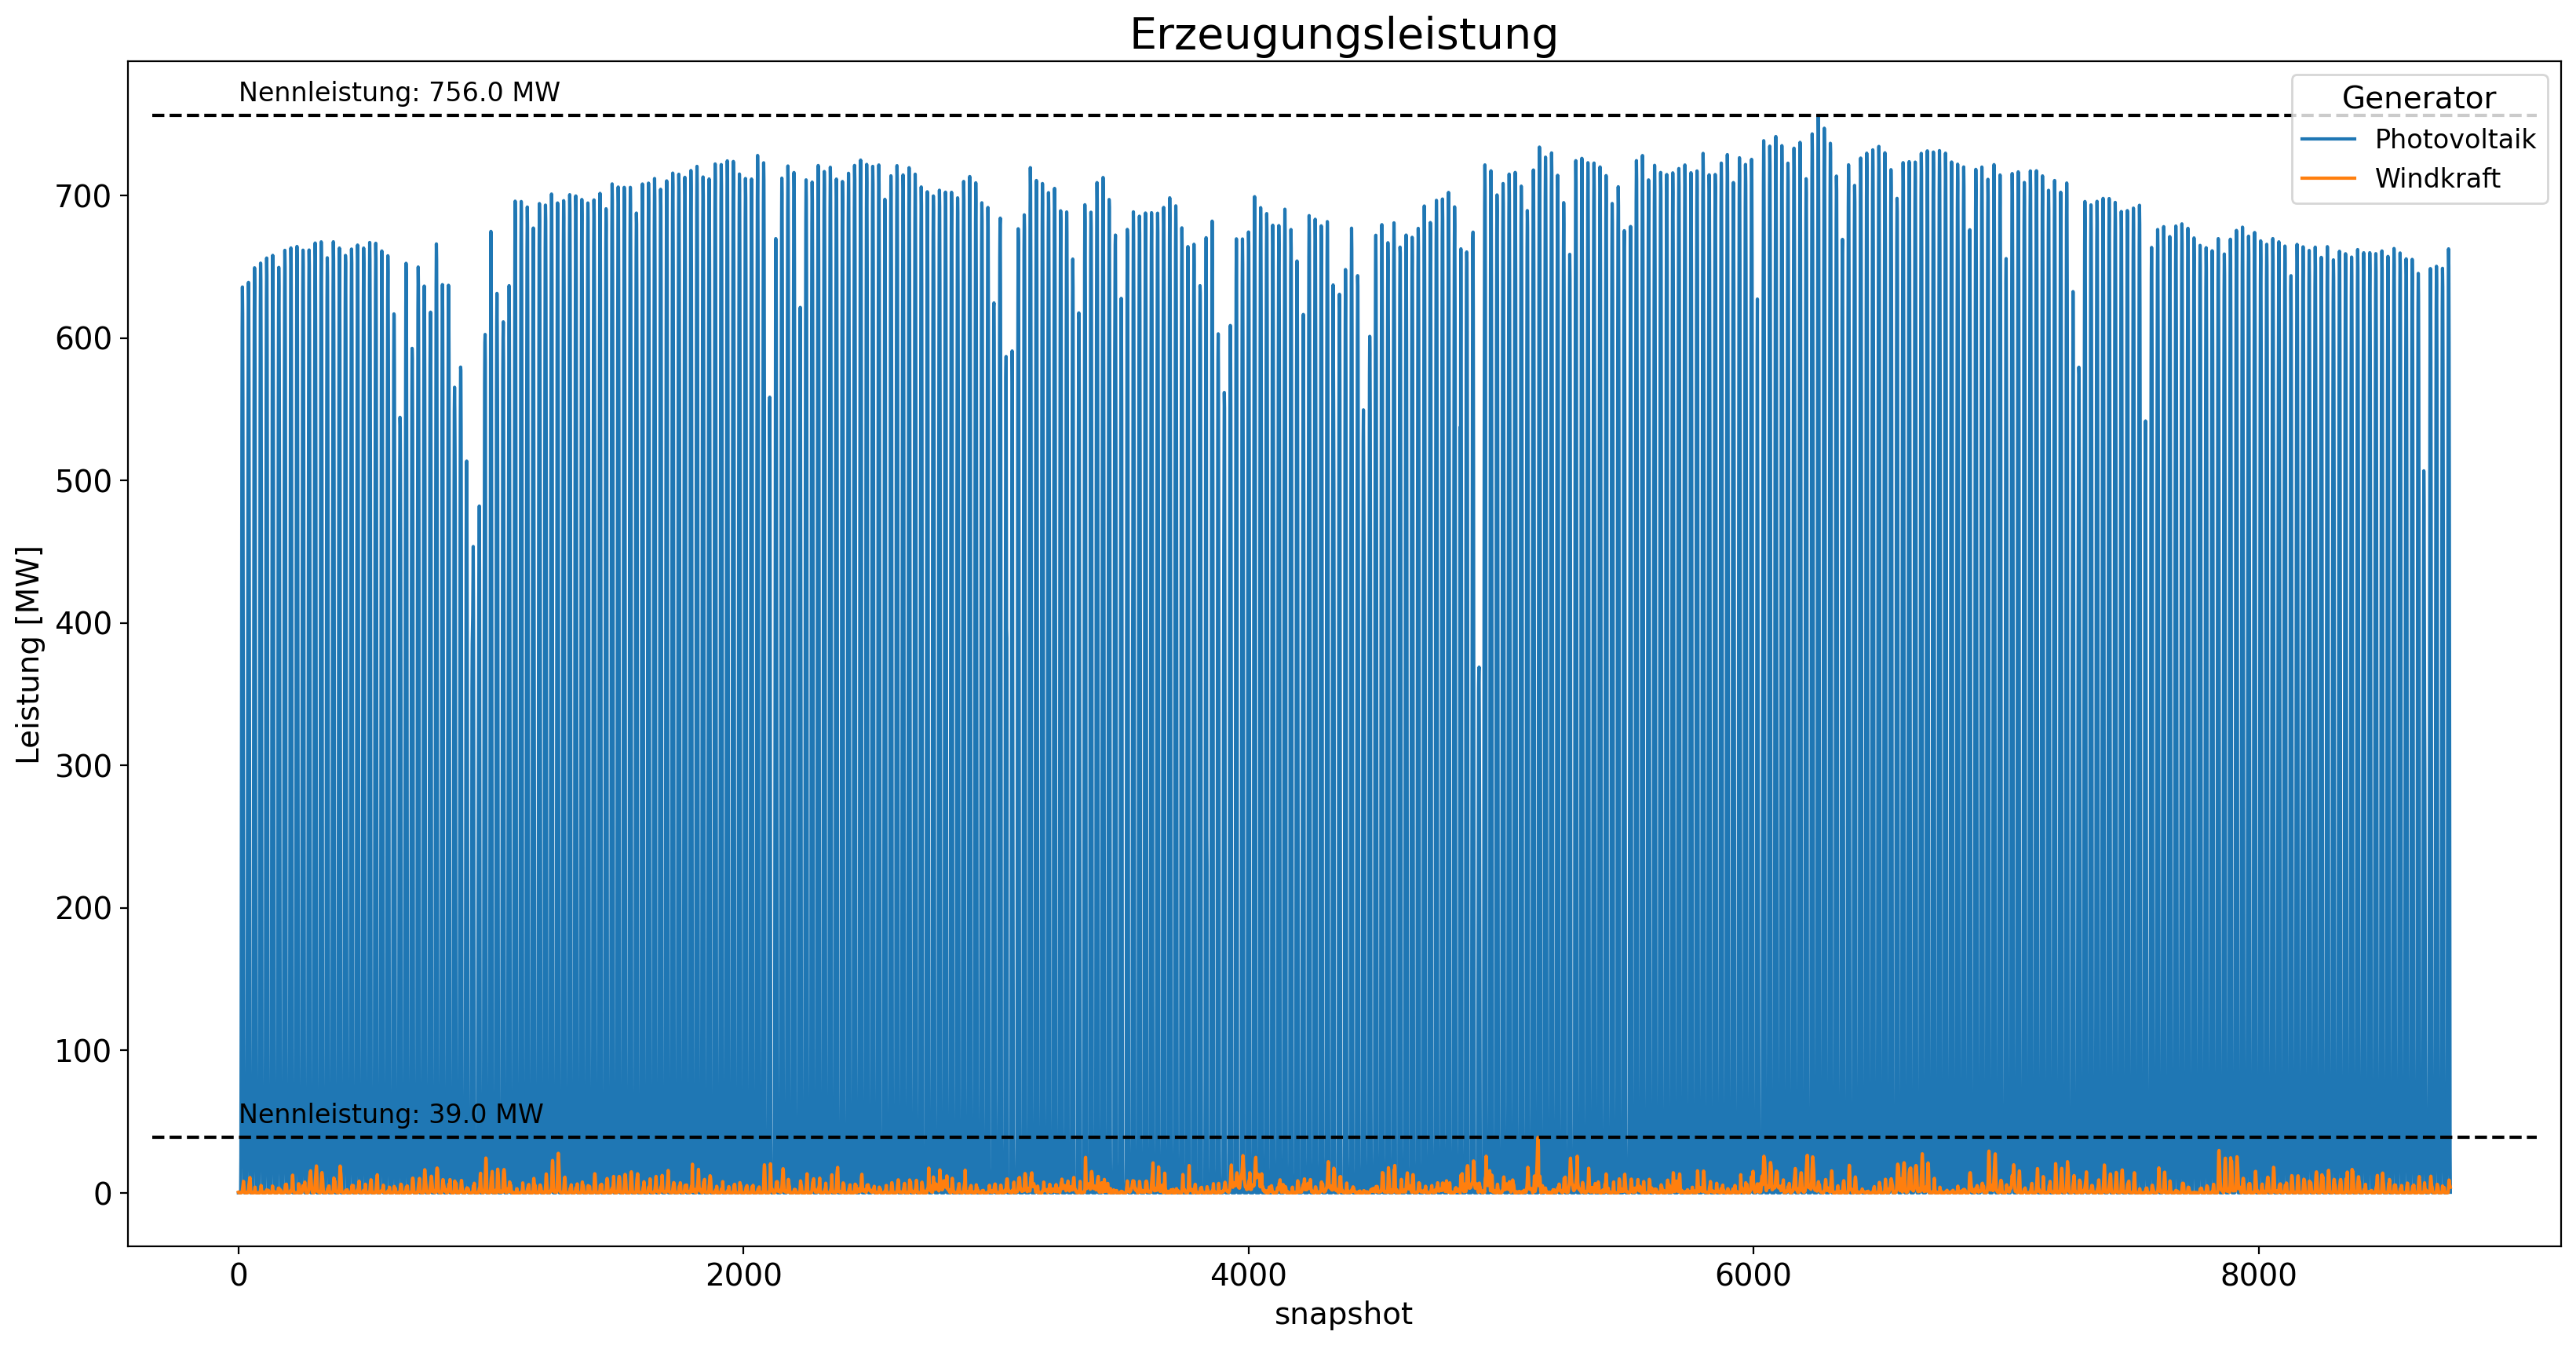

In [26]:
# Darstellung der optimierten Erzeugungsleistung

ax = (network.generators_t.p).plot()

plt.axhline(y=network.generators_t.p['Photovoltaik'].max(), xmin=0.01, xmax=0.99, color = 'black', linestyle = "--")
plt.axhline(y=network.generators_t.p['Windkraft'].max(), xmin=0.01, xmax=0.99, color = 'black', linestyle = "--")

plt.text(s = 'Nennleistung: '+str(network.generators.p_nom_opt.round(0)['Photovoltaik'])+' MW' , y = network.generators_t.p['Photovoltaik'].max() + 10, x = 0, color = 'black', fontsize = 12)
plt.text(s = 'Nennleistung: '+str(network.generators.p_nom_opt.round(0)['Windkraft'])+' MW', y = network.generators_t.p['Windkraft'].max() + 10, x = 0, color = 'black', fontsize = 12)

ax.set_title('Erzeugungsleistung')
ax.set_ylabel("Leistung [MW]")
plt.show()                  

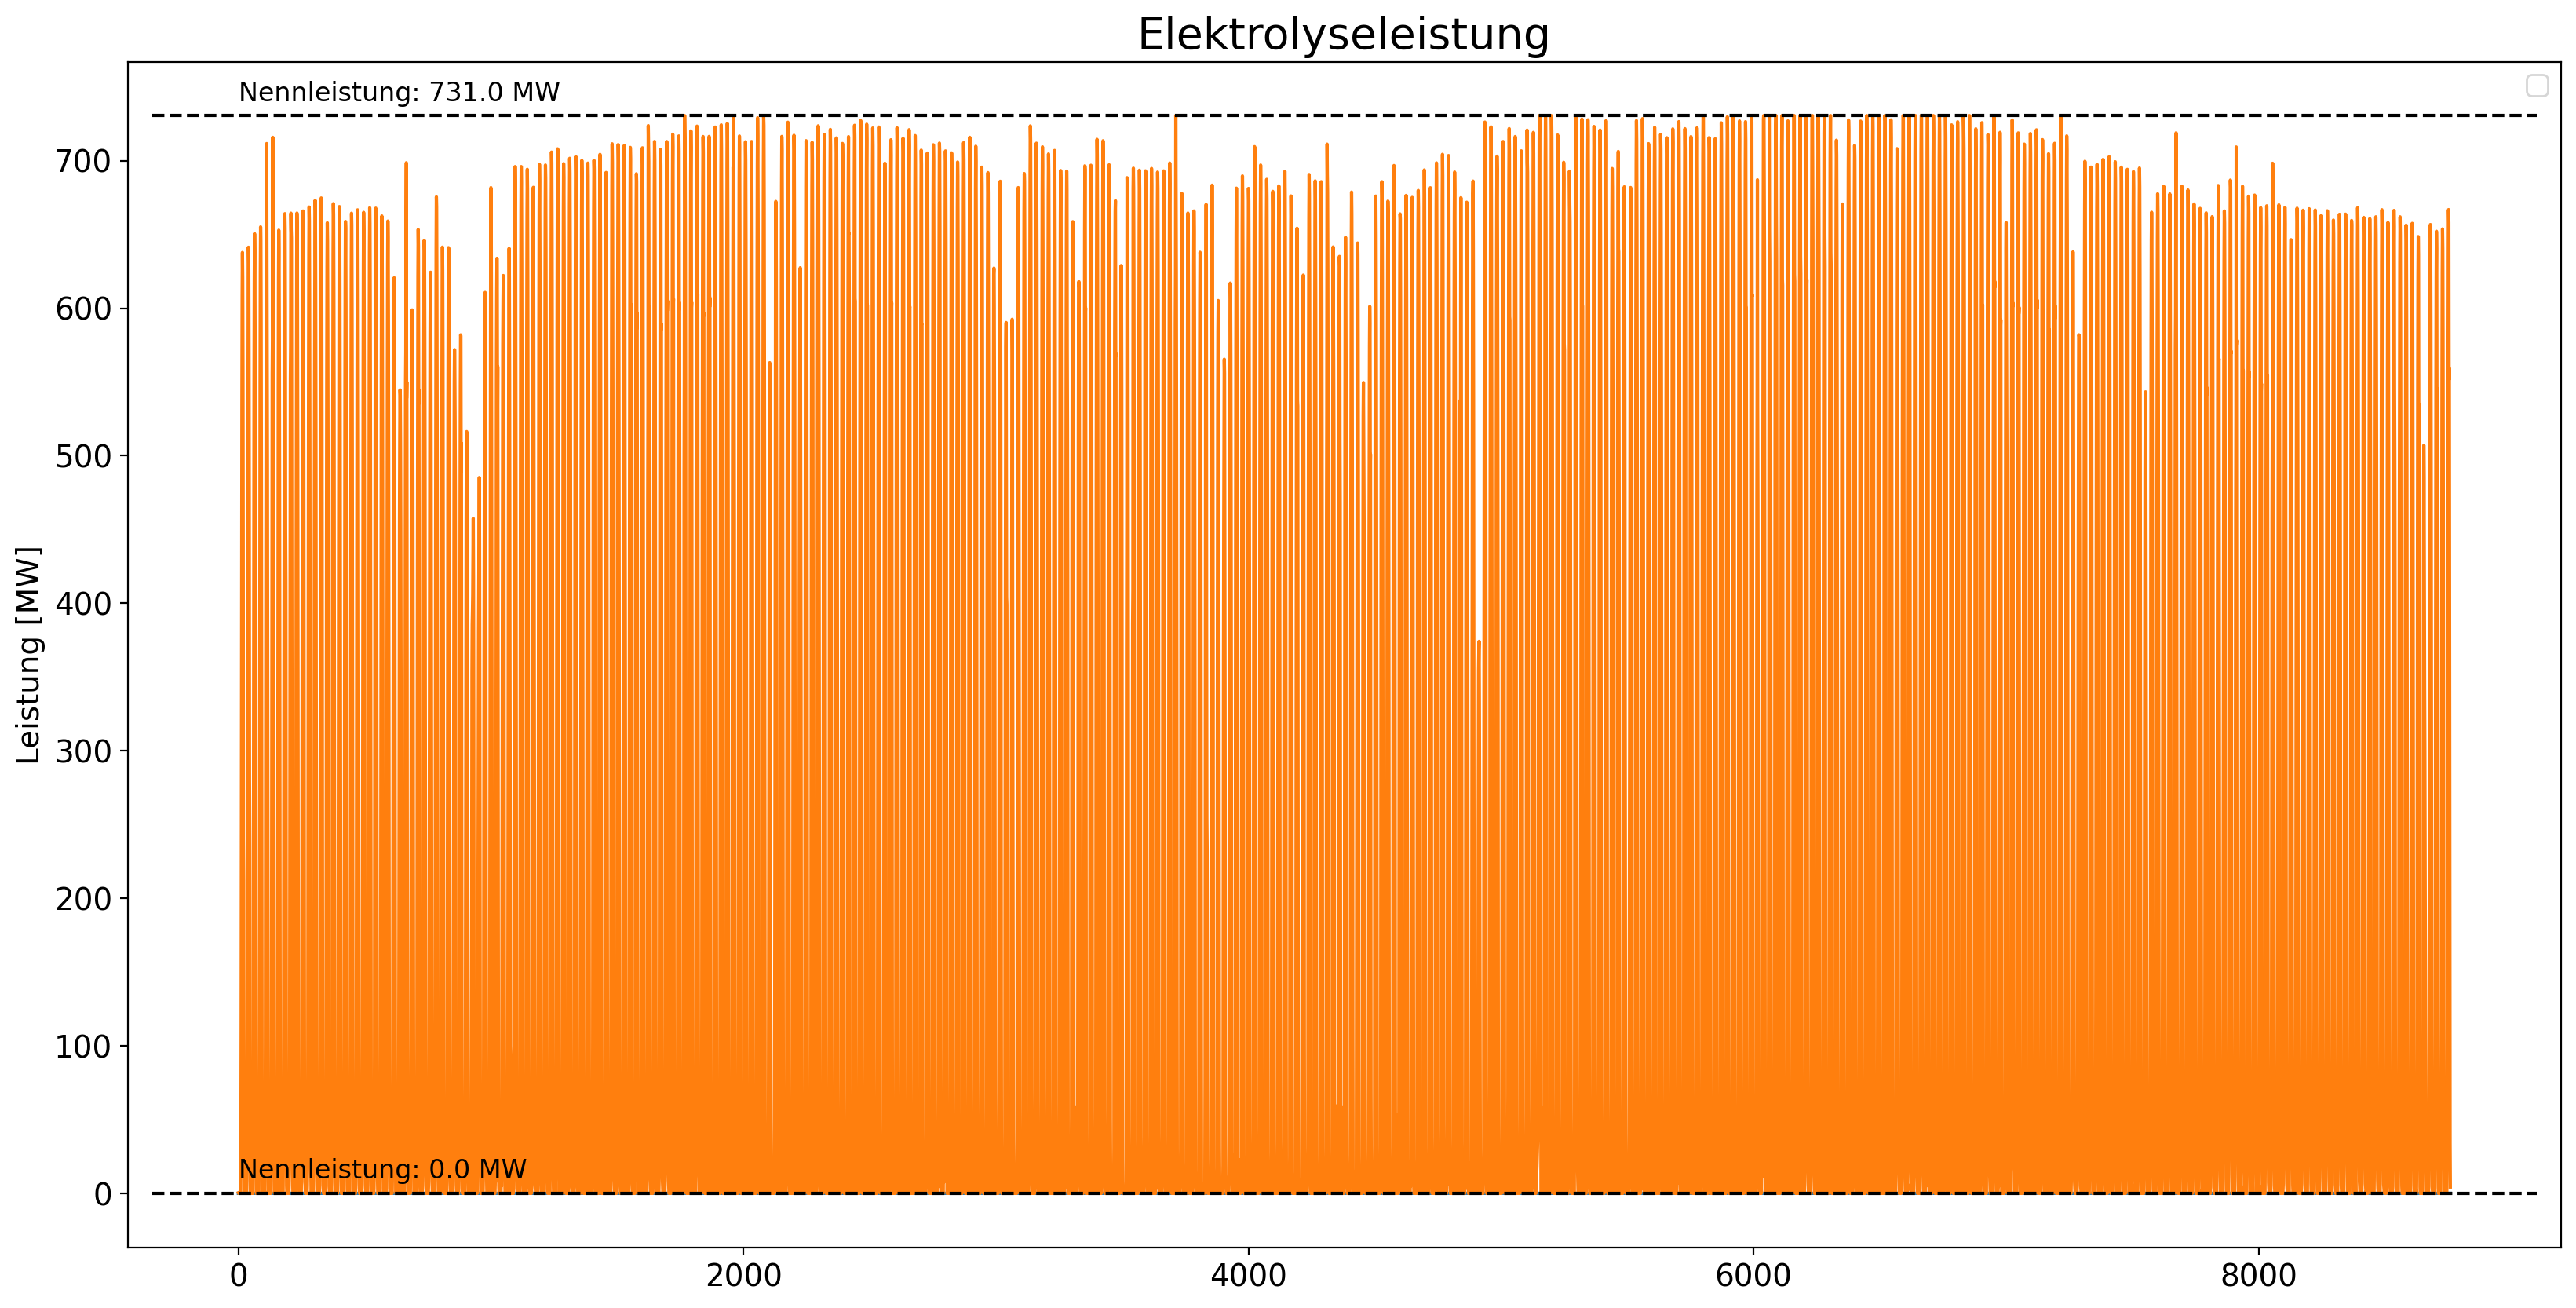

In [27]:
# Darstellung der optimierten Elektrolyseleistung

fig, ax = plt.subplots()

ax.plot(network.links_t.p0['PEMEL'])
ax.plot(network.links_t.p0['AEL'])
#ax.plot(network.links_t.p0['HTEL'])

plt.axhline(y=network.links_t.p0['PEMEL'].max(), xmin=0.01, xmax=0.99, color = 'black', linestyle = "--")
plt.axhline(y=network.links_t.p0['AEL'].max(), xmin=0.01, xmax=0.99, color = 'black', linestyle = "--")

plt.text(s = 'Nennleistung: '+str(network.links.p_nom_opt.round(0)['PEMEL'])+' MW' , y = network.links_t.p0['PEMEL'].max() + 10, x = 0, color = 'black', fontsize = 12)
plt.text(s = 'Nennleistung: '+str(network.links.p_nom_opt.round(0)['AEL'])+' MW', y = network.links_t.p0['AEL'].max() + 10, x = 0, color = 'black', fontsize = 12)

ax.legend()

ax.set_title('Elektrolyseleistung')
ax.set_ylabel("Leistung [MW]")
plt.show()         

### Vergleich von Umwandlung und Ferntransport

<AxesSubplot:xlabel='snapshot', ylabel='Leistung in MW'>

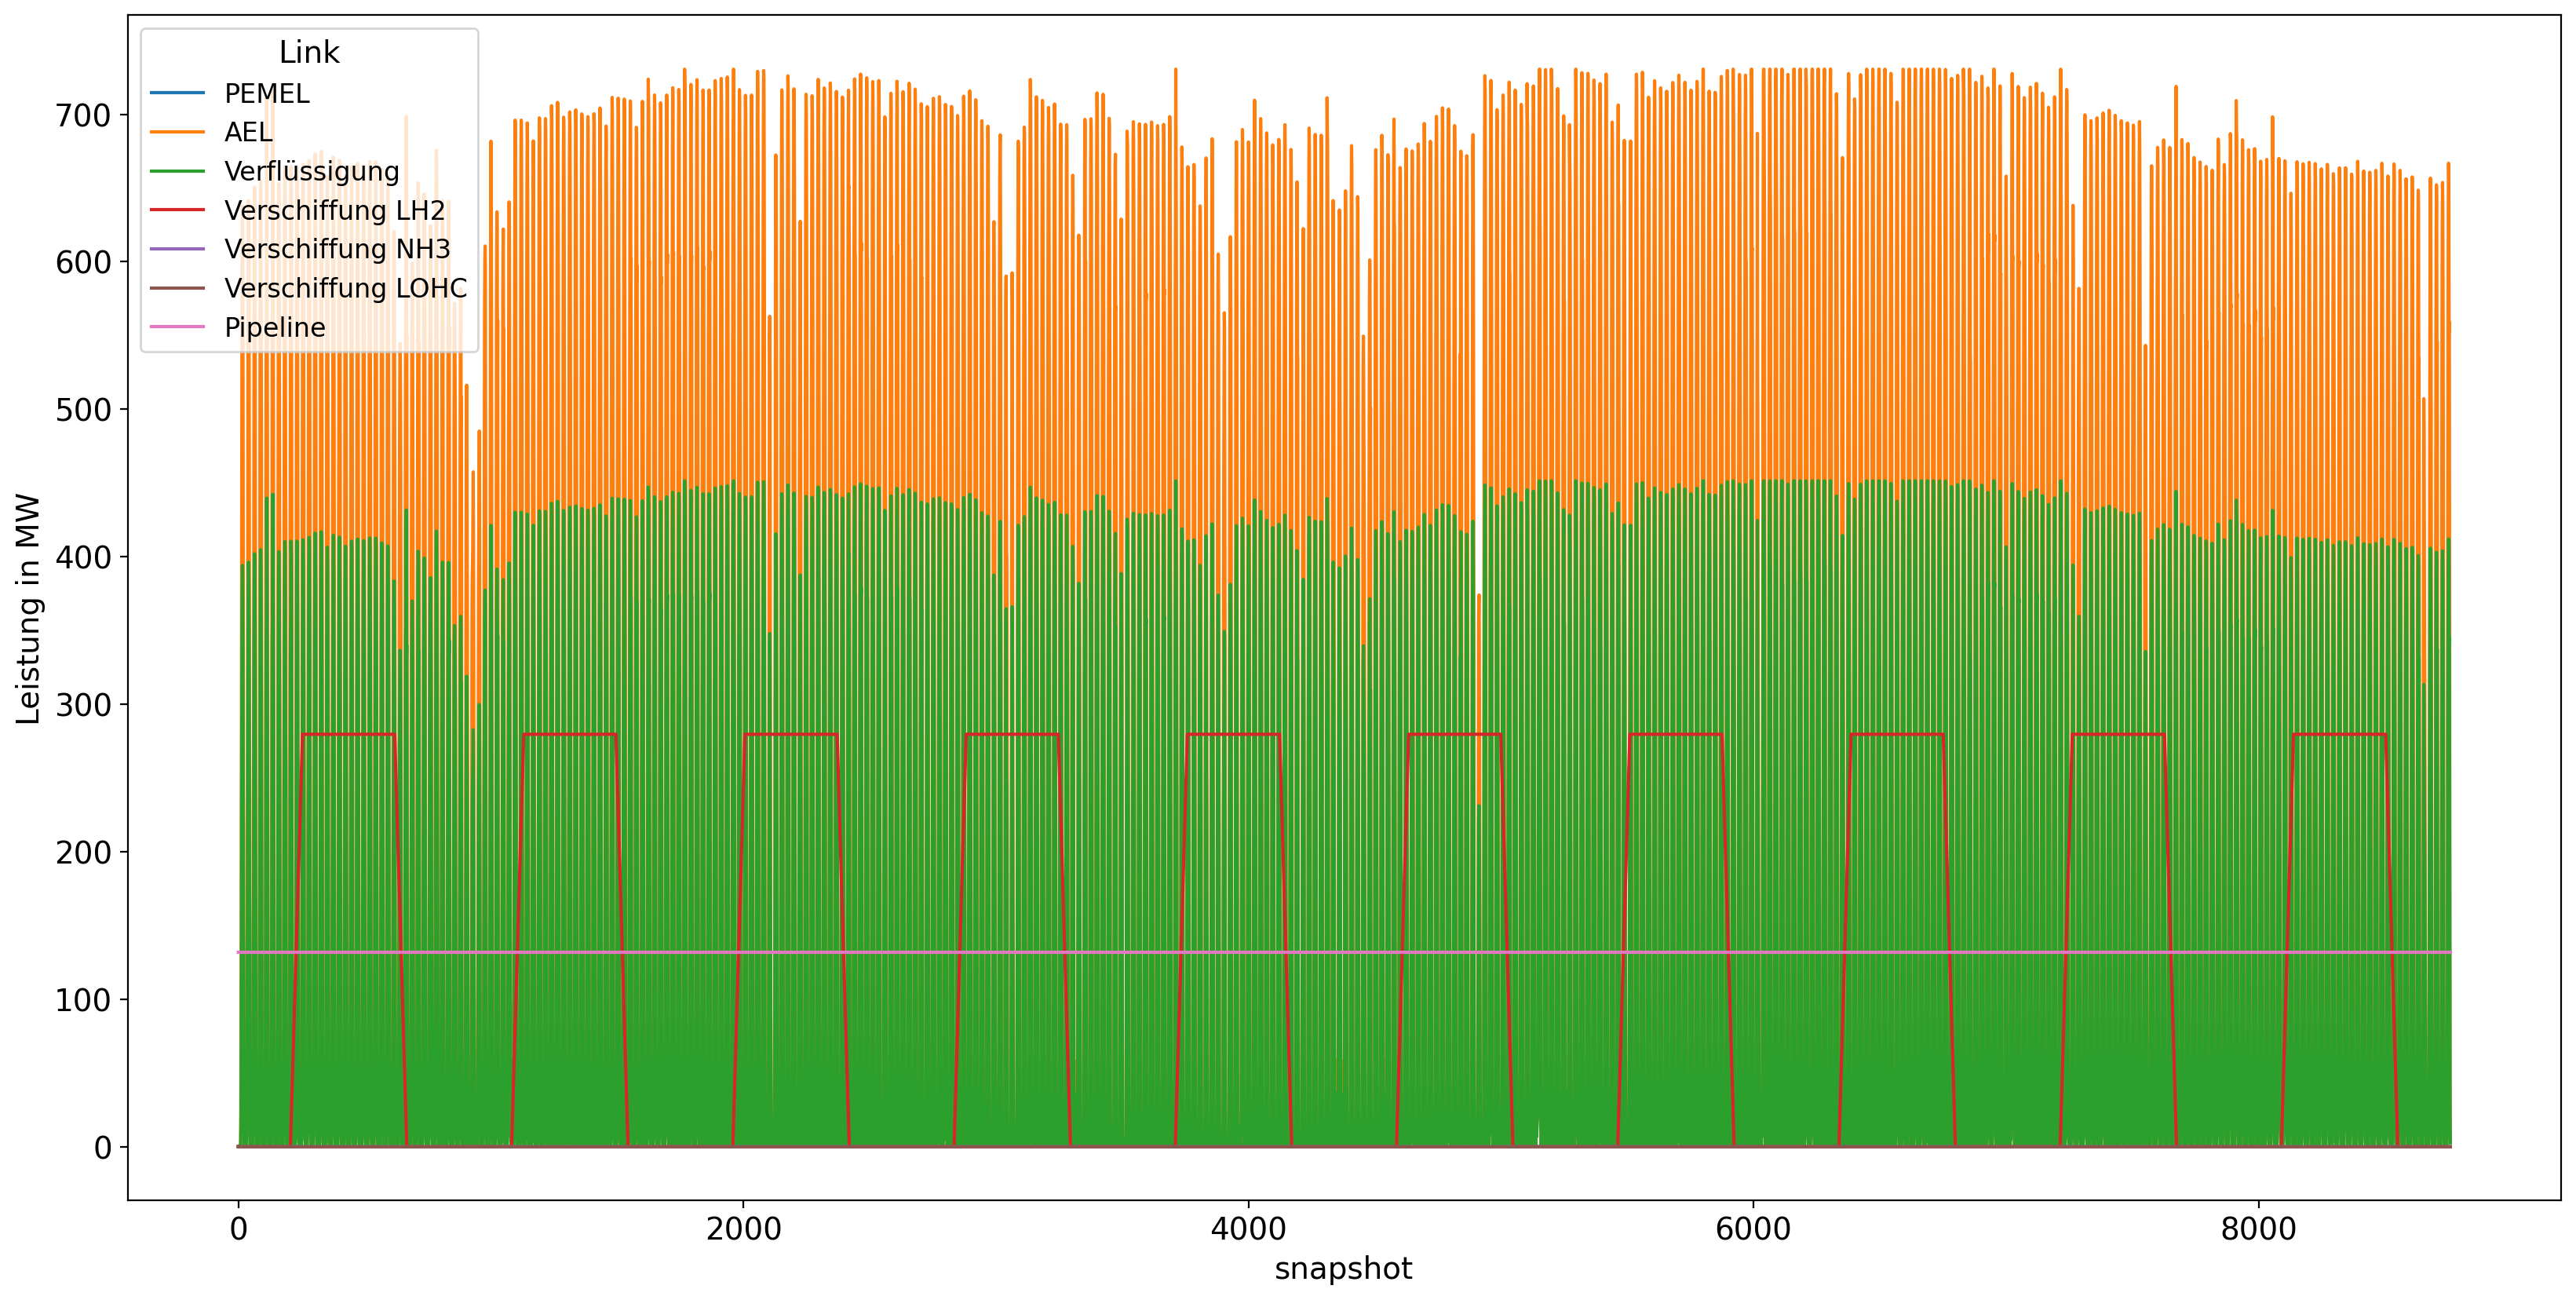

In [28]:
network.links_t.p0.plot(ylabel = 'Leistung in MW')

### Vergleich von Speicherung und Ferntransport

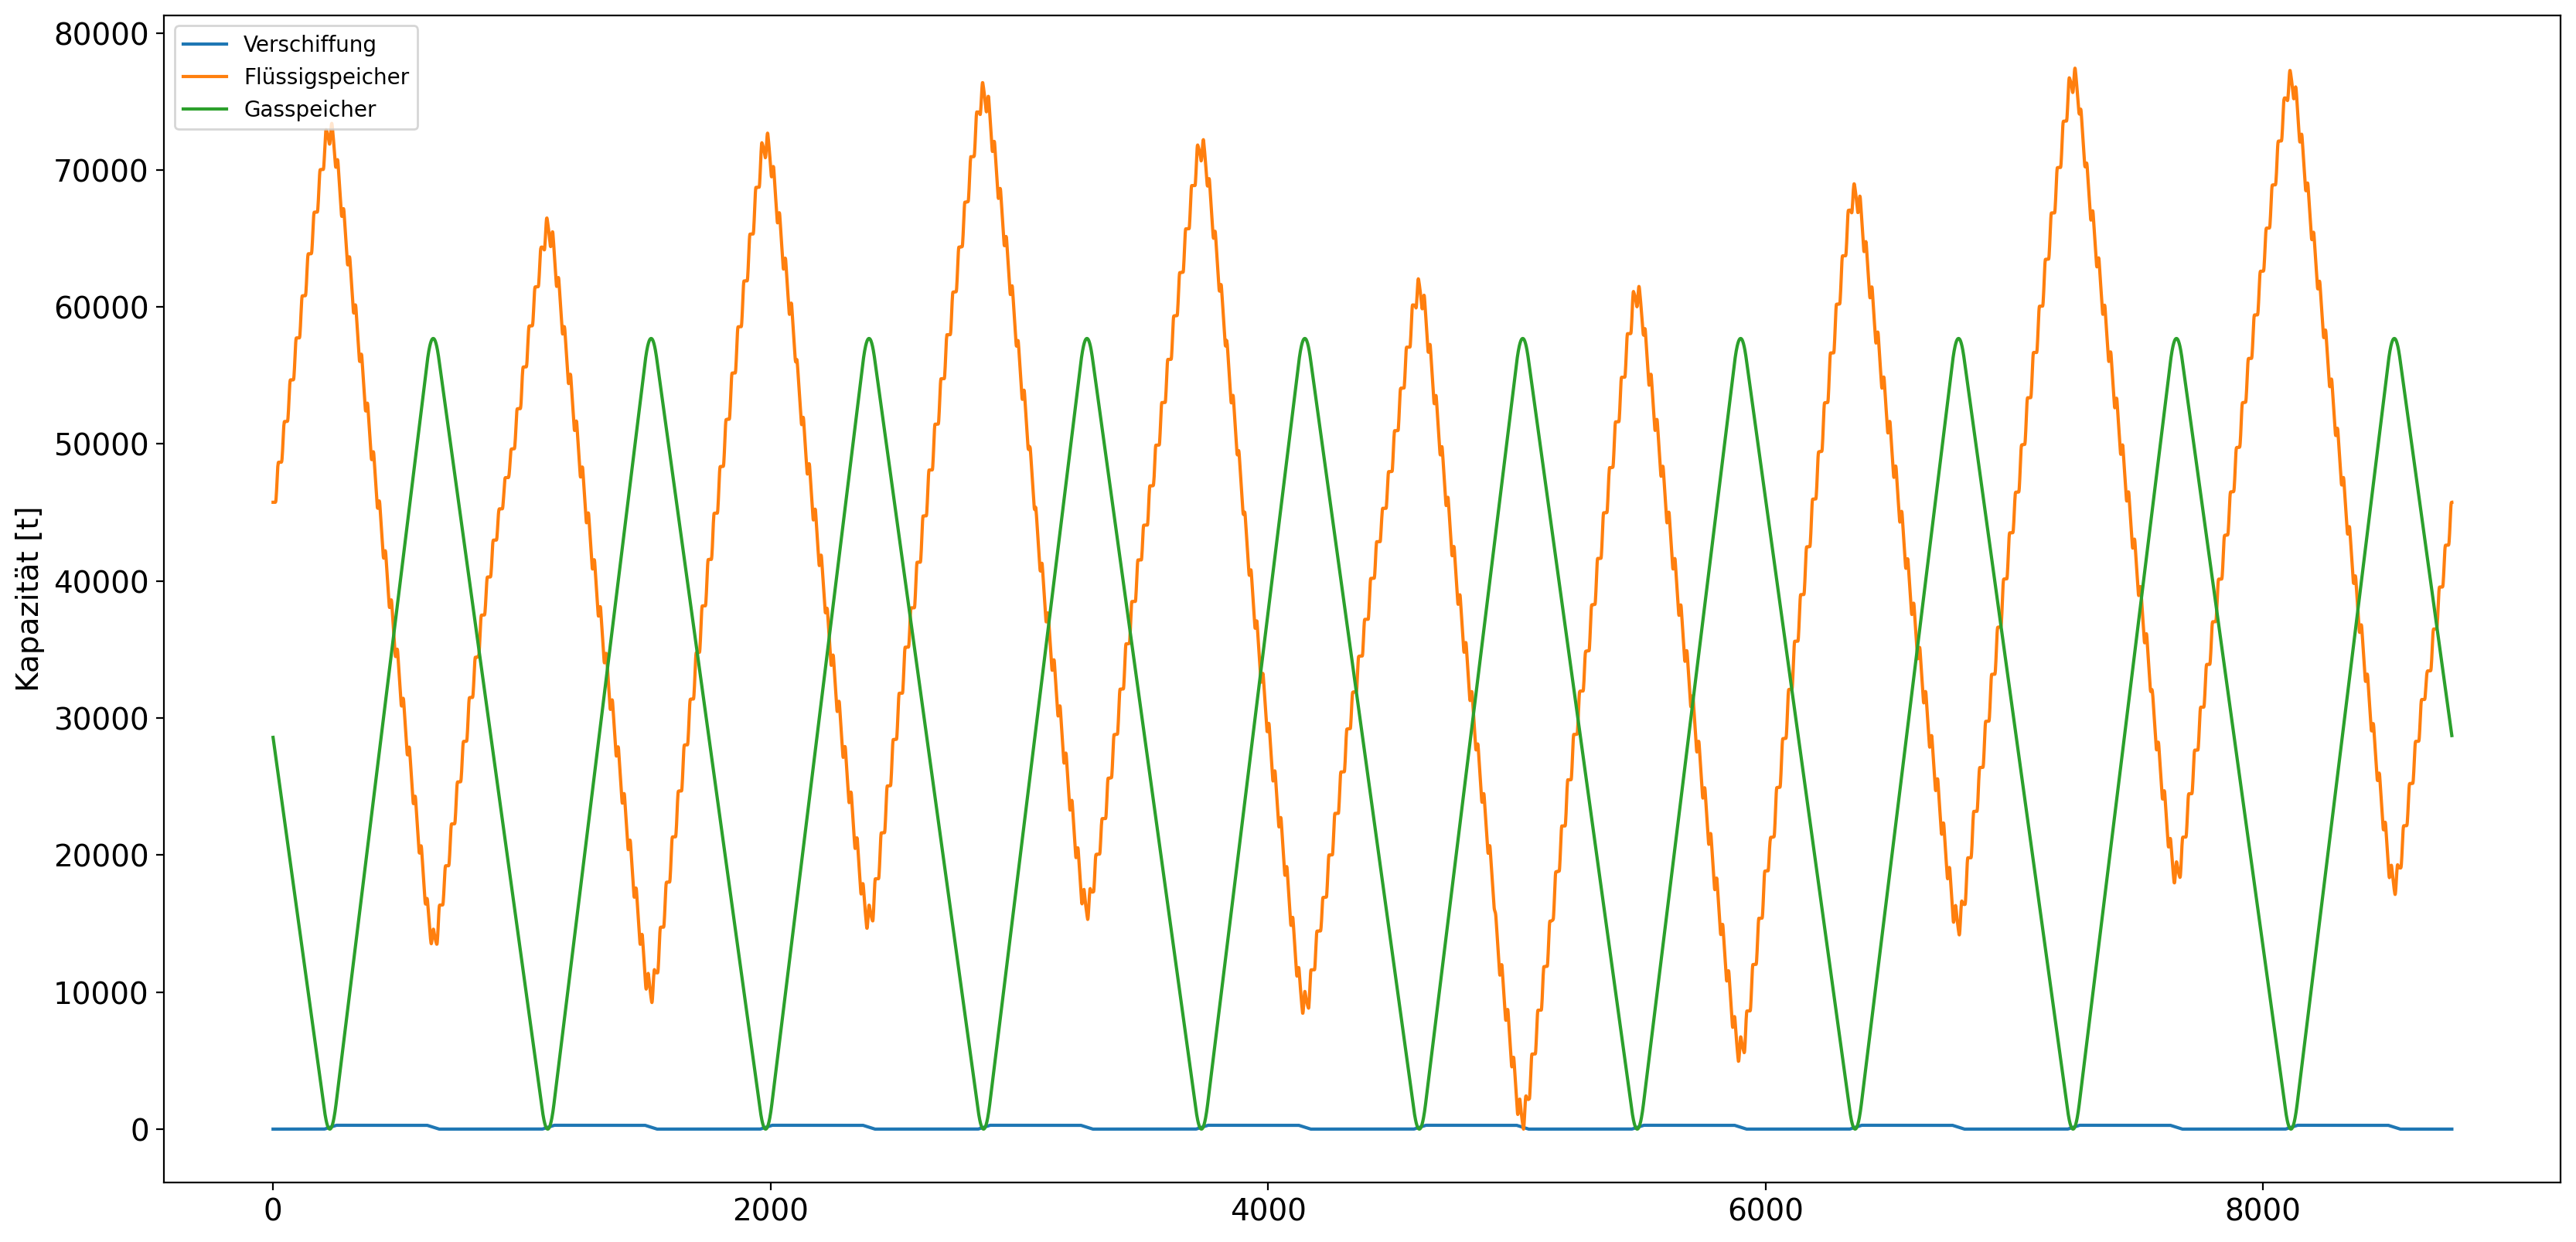

In [29]:
labels = ('Verschiffung','Flüssigspeicher','Gasspeicher')
fig, ax1 = plt.subplots(sharey = True)

#ax2 = ax1.twinx()
ax1.plot(network.links_t.p0['Verschiffung LH2'],
        label = 'Verschiffung')
ax1.plot(network.stores_t.e['Flüssigspeicher'],
        label = 'Flüssigspeicher')
ax1.plot(network.stores_t.e['Gasspeicher'],
        label = 'Gasspeicher')

ax1.legend(loc='upper left', prop=dict(size=10))
ax1.set_ylabel('Kapazität [t]')

plt.show()

In [30]:
# Funktion für die Abbildungen

def Jahresverlauf (Titel, Zeitstempel, Leistung, xlabel, ylabel):

  fig = plt.figure(figsize=(19,8))

 

  ax1 = fig.add_axes([1, 1, 1, 1])
  ax1.set_title(Titel,weight='bold',fontsize=15)
  ax1.plot(Zeitstempel,Leistung,c='green')
  plt.xlabel(xlabel,fontsize=15 )
  plt.ylabel(ylabel,fontsize=15)

 

  plt.show()

In [31]:
#Jahresverlauf('Stromerzeugung aus Photovoltaik',dataset_df.index, network.generators_t.p['Photovoltaik'],'Zeit','Leistung')

In [32]:
#Jahresverlauf('Stromerzeugung aus Windkraft',dataset_df.index, network.generators_t.p['Windkraft'],'Zeit','Leistung')

In [33]:
#Jahresverlauf('Elektrolyse',dataset_df.index, dataset_df['Elektrolyse'],'Zeit','Leistung')

In [34]:
#Jahresverlauf('Ferntransport',dataset_df.index, dataset_df['Kapazität_Schiff'],'Zeit','Leistung')

# Werkstatt

In [35]:
# Test

# Produzierte Wasserstoffmenge bei der Elektrolyse in kg
hydrogen_production_kg = network.links_t.p0.sum()/hydrogen_energy_content*1000 #kg/a

# Betriebskosten pro Jahr
marginal_cost_links = network.links.marginal_cost * network.links_t.p0.sum() # €/a
marginal_cost_stores = network.stores.marginal_cost * network.stores_t.e.sum() # €/a

# Investitionskosten pro Jahr
capital_cost_links = network.links.capital_cost * network.links.p_nom_opt # €
capital_cost_stores = network.stores.capital_cost * network.stores.e_nom_opt # €

# Lebenszeit
lifetime_links = network.links.lifetime # €
lifetime_stores = network.stores.lifetime # €

# Kilopreis Links
hydrogen_price_links = ((((capital_cost_links/lifetime_links)+marginal_cost_links))/hydrogen_production_kg).round(2)

# Kilopreis Stores
hydrogen_price_stores = ((((capital_cost_stores/lifetime_stores)+marginal_cost_stores))/hydrogen_production_kg).round(2)



In [36]:
hydrogen_price_links#['AEL']

Link
PEMEL                 NaN
AEL                  4.80
Verflüssigung        0.20
Verschiffung LH2     0.00
Verschiffung NH3      NaN
Verschiffung LOHC     NaN
Pipeline             0.16
dtype: float64

In [37]:
# Kilopreis der Links - ACHTUNG: veraltet und vermutlich falsch!!!
Linkkosten = ((network.links.p_nom_opt * network.links.capital_cost)/network.links.lifetime+network.links.marginal_cost*hydrogen_demand_kg*(33/1000))/hydrogen_demand_kg
Linkkosten=pd.DataFrame(Linkkosten,columns=['Value [€/kg]'])
Linkkosten['Link']=Linkkosten.index
Linkkosten=Linkkosten.reset_index(drop=True)
Linkkosten=Linkkosten[['Link','Value [€/kg]']]
#Linkkosten

In [38]:
# Kilopreis der Speicher - ACHTUNG: veraltet und vermutlich falsch!!!
Speicherkosten = ((network.stores.e_nom_opt * network.stores.capital_cost)/network.stores.lifetime+network.stores.marginal_cost*hydrogen_demand_kg*(33/1000))/hydrogen_demand_kg
Speicherkosten=pd.DataFrame(Speicherkosten,columns=['Value [€/kg]'])
Speicherkosten['Speicher']=Speicherkosten.index
Speicherkosten=Speicherkosten.reset_index(drop=True)
Speicherkosten=Speicherkosten[['Speicher','Value [€/kg]']]
#Speicherkosten

In dieser Grafik spiele ich gerade ein bisschen rum, um eine Abbildung für die Präsentation morgen zu bekommen

TODO: Anstatt auf nummerierte Zeilen zuzugreifen, lieber auf die Benennung bzw inde

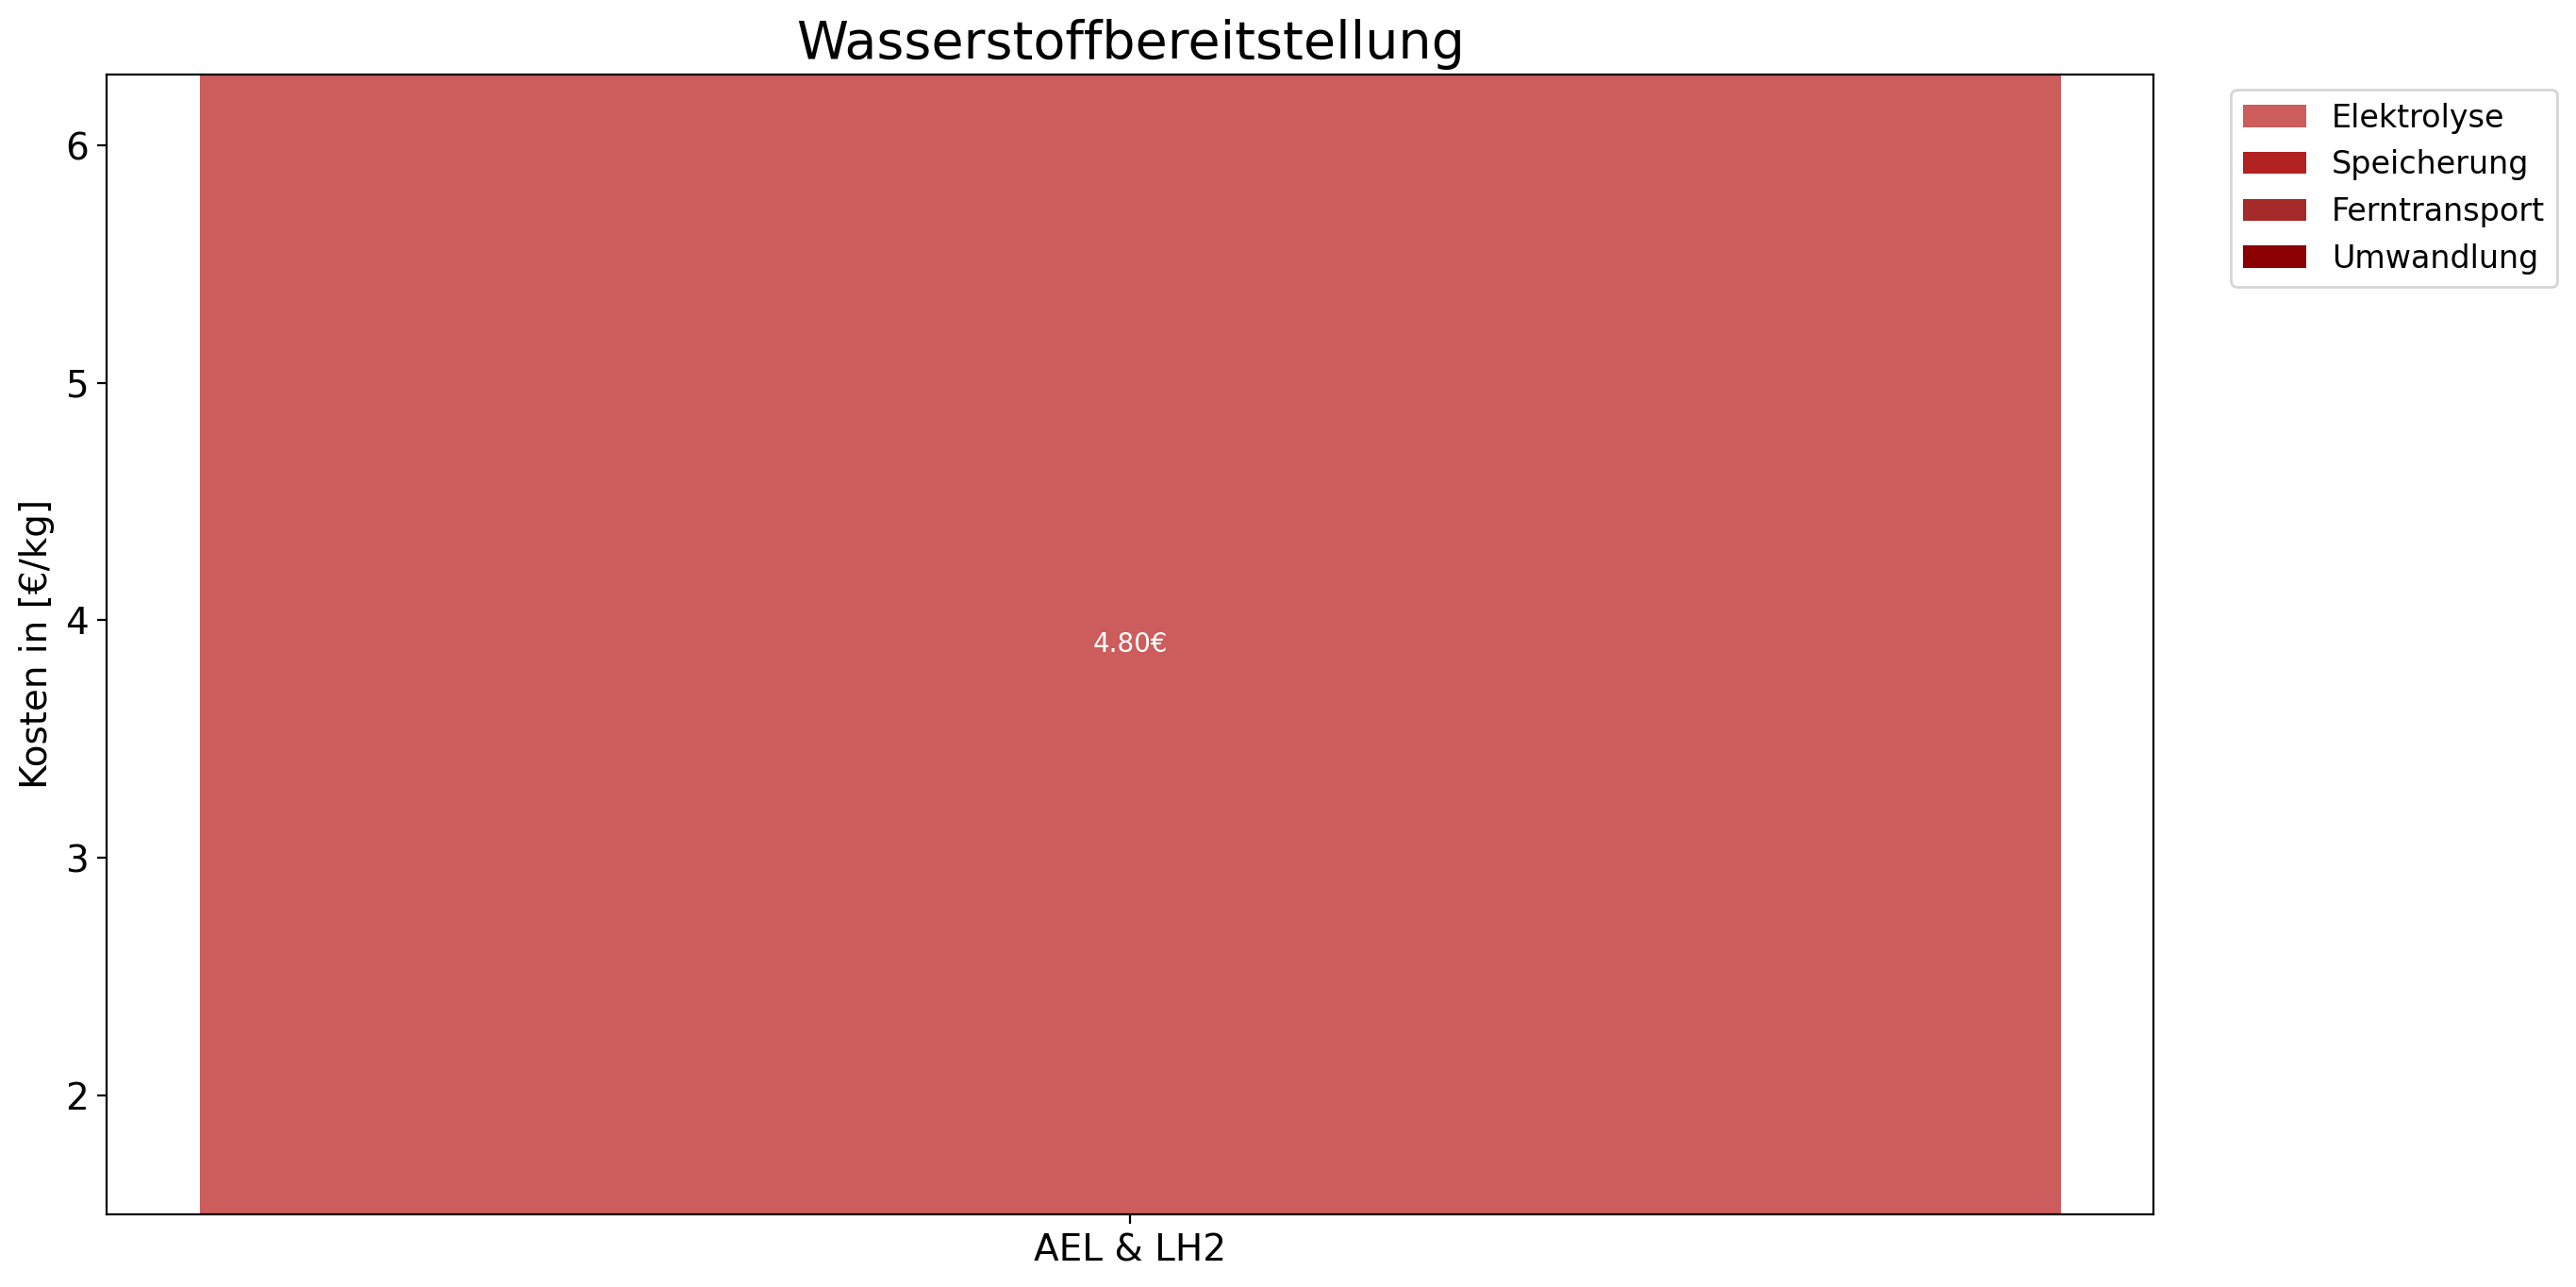

In [39]:
# Übersicht der Kilopreise

labels = ['PEM & LH2', 'AEL & LH2']
Stromkosten = np.array([1.5,1.5])

Elektrolyse = np.array([hydrogen_price_links['PEMEL'],
                        hydrogen_price_links['AEL']])
Umwandlung = np.array([hydrogen_price_links['Verflüssigung'],
                       hydrogen_price_links['Verflüssigung']])
Ferntransport_1 = np.array([hydrogen_price_links['Verschiffung LH2'],
                            hydrogen_price_links['Verschiffung LH2']])
Inlandstransport = np.array([hydrogen_price_links['Pipeline'],
                             hydrogen_price_links['Pipeline']])

Speicherung = np.array([Speicherkosten['Value [€/kg]'][2]+Speicherkosten['Value [€/kg]'][4],
                        Speicherkosten['Value [€/kg]'][2]+Speicherkosten['Value [€/kg]'][4]])

Sonstige= np.array([0.1,0.3])
# the width of the bars: can also be len(x) sequence
width=0.5
fig, ax = plt.subplots(figsize=(14,8))
#x_pos = [-2,0,2]
#ax.bar(labels, Stromkosten, label='Stromkosten',width=width,color='lightcoral')
ax.bar(labels, Elektrolyse, bottom=Stromkosten,
       label='Elektrolyse',width=width,color='indianred')
ax.bar(labels, Speicherung, bottom=Stromkosten+Elektrolyse,
       label='Speicherung',width=width,color='firebrick')
ax.bar(labels, Ferntransport_1, bottom=Stromkosten+Elektrolyse+Speicherung,
       label='Ferntransport',width=width,color='brown')
#ax.bar(labels, Inlandstransport, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1,
#       label='Inlandstransport',width=width,color='maroon')
ax.bar(labels, Umwandlung, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1+Inlandstransport,
       label='Umwandlung',width=width,color='darkred')
#ax.bar(labels, Sonstige, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1+Inlandstransport+Umwandlung,
#       label='Sonstige',width=width,color='red')

ax.set_ylabel('Kosten in [€/kg]')
ax.set_title('Wasserstoffbereitstellung')
ax.legend(loc='upper right')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.02f}€'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',
            color='white',
            fontsize=10,
            )
  

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
#plt.xticks(x_pos, labels)
plt.show()

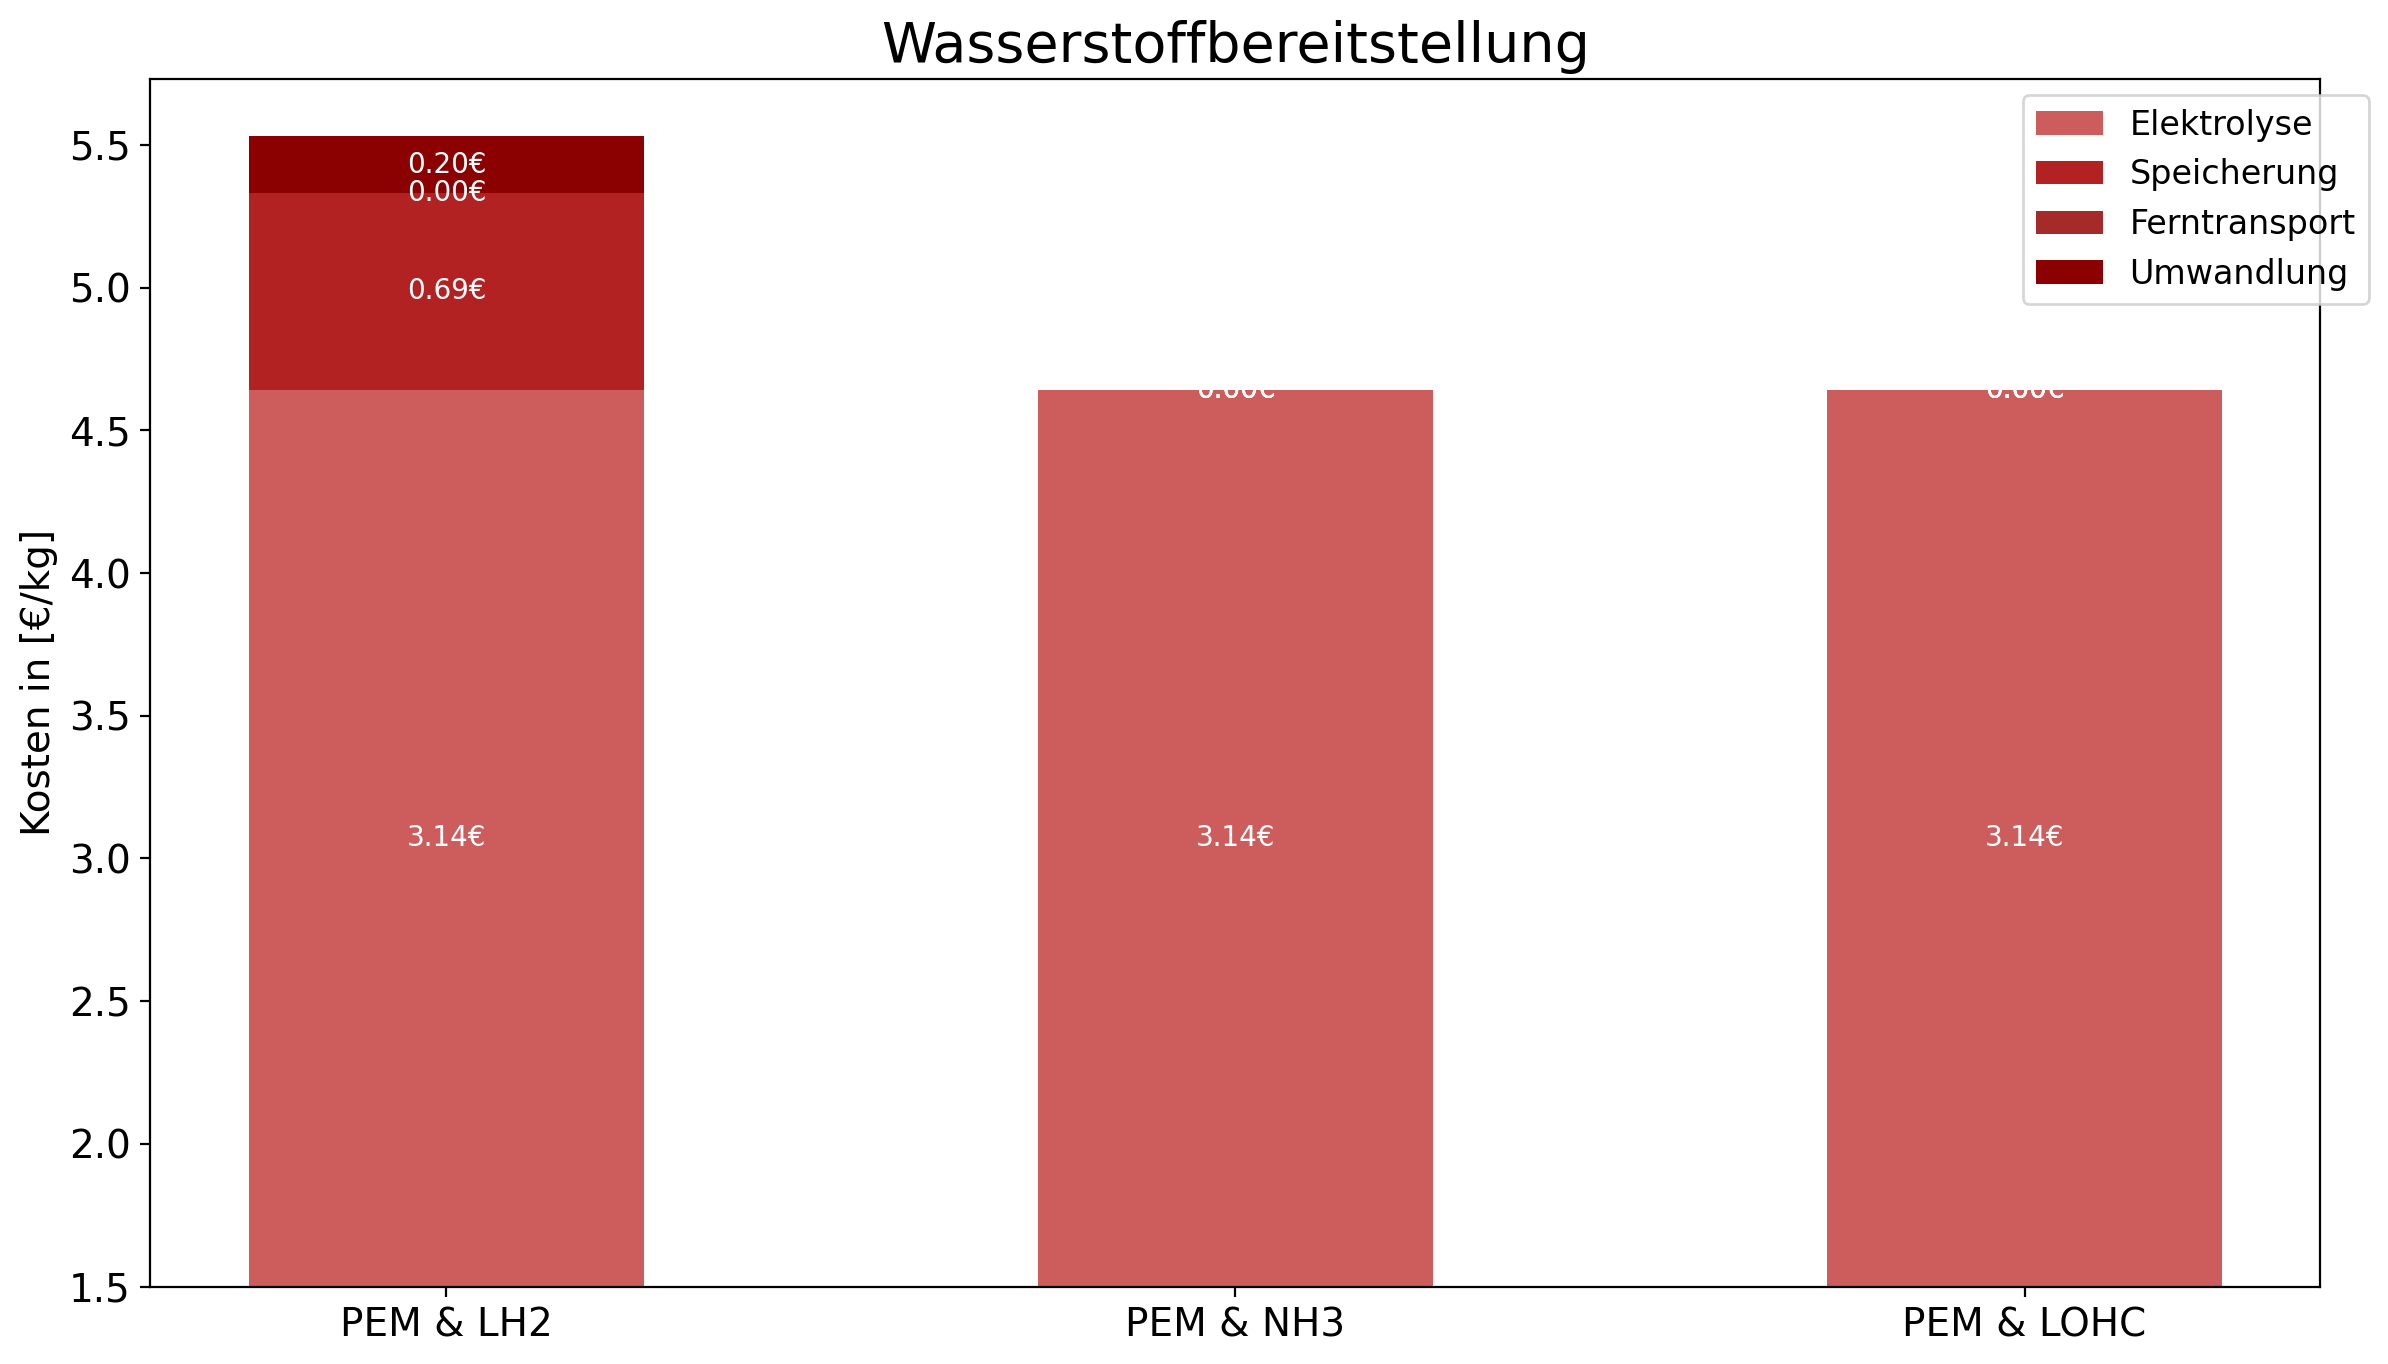

In [40]:
# Übersicht der Kilopreise

labels = ['PEM & LH2', 'PEM & NH3', 'PEM & LOHC']
Stromkosten = np.array([1.5,1.5,1.5])

Elektrolyse = np.array([Linkkosten['Value [€/kg]'][0],
                        Linkkosten['Value [€/kg]'][0],
                        Linkkosten['Value [€/kg]'][0]])
Umwandlung = np.array([Linkkosten['Value [€/kg]'][2],0,0])
Ferntransport_1 = np.array([Linkkosten['Value [€/kg]'][3],0,0])
Inlandstransport = np.array([Linkkosten['Value [€/kg]'][4],0,0])

Speicherung = np.array([Speicherkosten['Value [€/kg]'][2]+Speicherkosten['Value [€/kg]'][4],0,0])

Sonstige= np.array([0.1,0.3,0.5])
# the width of the bars: can also be len(x) sequence
width=0.5
fig, ax = plt.subplots(figsize=(14,8))
#x_pos = [-2,0,2]
#ax.bar(labels, Stromkosten, label='Stromkosten',width=width,color='lightcoral')
ax.bar(labels, Elektrolyse, bottom=Stromkosten,
       label='Elektrolyse',width=width,color='indianred')
ax.bar(labels, Speicherung, bottom=Stromkosten+Elektrolyse,
       label='Speicherung',width=width,color='firebrick')
ax.bar(labels, Ferntransport_1, bottom=Stromkosten+Elektrolyse+Speicherung,
       label='Ferntransport',width=width,color='brown')
#ax.bar(labels, Inlandstransport, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1,
#       label='Inlandstransport',width=width,color='maroon')
ax.bar(labels, Umwandlung, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1+Inlandstransport,
       label='Umwandlung',width=width,color='darkred')
#ax.bar(labels, Sonstige, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1+Inlandstransport+Umwandlung,
#       label='Sonstige',width=width,color='red')

ax.set_ylabel('Kosten in [€/kg]')
ax.set_title('Wasserstoffbereitstellung')
ax.legend(loc='upper right')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.02f}€'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',
            color='white',
            fontsize=10,
            )
  

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
#plt.xticks(x_pos, labels)
plt.show()

Ursprüngliche Grafik

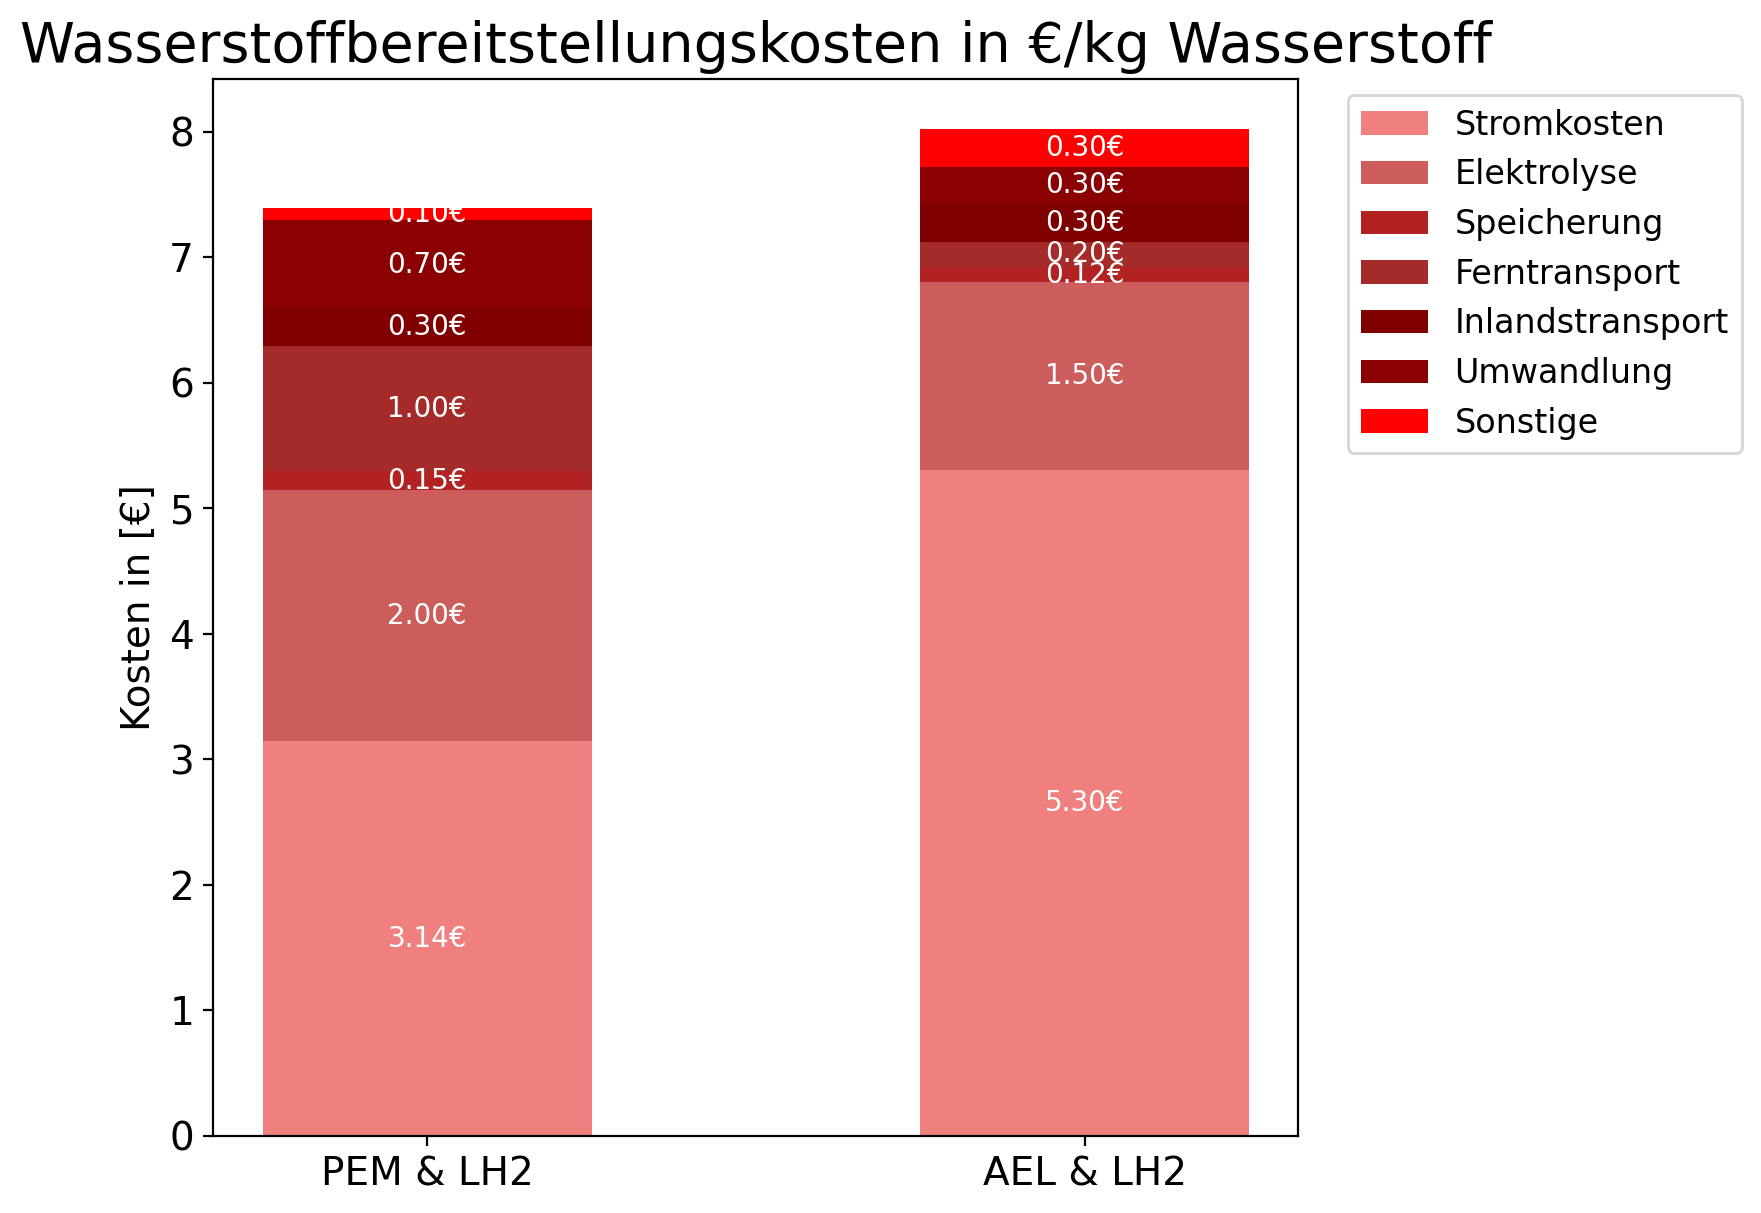

In [41]:
# Übersicht der Kilopreise

labels = ['PEM & LH2', 'AEL & LH2']
Stromkosten = np.array([Linkkosten['Value [€/kg]'][0],Linkkosten['Value [€/kg]'][1]])
Elektrolyse = np.array([2,1.5])
Speicherung = np.array([0.15,0.12])
Ferntransport_1 = np.array([1,0.2])
Inlandstransport = np.array([0.3,0.3])
Umwandlung = np.array([0.7,0.3])
Sonstige= np.array([0.1,0.3])
# the width of the bars: can also be len(x) sequence
width=0.5
fig, ax = plt.subplots(figsize=(7,7))
#x_pos = [-2,0,2]
ax.bar(labels, Stromkosten, label='Stromkosten',width=width,color='lightcoral')
ax.bar(labels, Elektrolyse, bottom=Stromkosten,
       label='Elektrolyse',width=width,color='indianred')
ax.bar(labels, Speicherung, bottom=Stromkosten+Elektrolyse,
       label='Speicherung',width=width,color='firebrick')
ax.bar(labels, Ferntransport_1, bottom=Stromkosten+Elektrolyse+Speicherung,
       label='Ferntransport',width=width,color='brown')
ax.bar(labels, Inlandstransport, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1,
       label='Inlandstransport',width=width,color='maroon')
ax.bar(labels, Umwandlung, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1+Inlandstransport,
       label='Umwandlung',width=width,color='darkred')
ax.bar(labels, Sonstige, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1+Inlandstransport+Umwandlung,
       label='Sonstige',width=width,color='red')

ax.set_ylabel('Kosten in [€]')
ax.set_title('Wasserstoffbereitstellungskosten in €/kg Wasserstoff')
ax.legend(loc='upper right')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.02f}€'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',
            color='white',
            fontsize=10,
            )
  

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
#plt.xticks(x_pos, labels)
plt.show()